# Задача #1  условие

Ниже даны результаты A/B-тестирования. 

Необходимо:

- Проанализировать эксперимент в python
- Оформить отчет в jupyter notebook со всеми расчетами
- Описать свои действия и написать выводы, которые можно сделать на основе результатов


### Описание колонок

Каждая отдельная строка – индивидуальная сессия

- `date` – Дата
- `deviceCategory` – Тип устройства
- `sourceMedium` – Источник и канал привлечения
- `experimentVariant` – Группа (варианта) эксперимента, в которую был определен пользователь
- `clickButtonOnMain` – Кликнул/не кликнул по кнопке на главной странице в рамках сеанса (1 – кликнул, или 0 – не кликнул)
- `sessionDuration` – Время проведенное на сайте в рамках сеанса


## Подготовительные работы
    Импортируем нужные библиотеки. Запишем нужные функции

In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, chi2_contingency
import statsmodels.api as sm
from tqdm.auto import tqdm
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )
plt.style.use('ggplot')

In [25]:
# Функция с KARPOV.COURSES, модуль статистики 
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

## Попялимя на данные :)
    Посмотрим на данные и подготовим их к работе

In [26]:
df = pd.read_csv('test_analyst_ab.csv', sep = ';',index_col=0) 
print(df.dtypes)
df.head()

date                 object
deviceCategory       object
sourceMedium         object
experimentVariant    object
clickButtonOnMain     int64
sessionDuration      object
dtype: object


,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,"123,109764978127"
2,2019-11-27,mobile,maz.com / referral,test,1,"135,604000573899"
3,2019-11-27,mobile,(direct) / (none),test,1,"134,451016589043"
4,2019-11-27,desktop,google / organic,test,1,"130,691086592426"
5,2019-11-27,mobile,google / organic,control,1,"117,617311178722"


In [27]:
df.sessionDuration = df.sessionDuration.replace(',','.', regex = True).astype(float)
df = df.astype({'clickButtonOnMain':'int'})

Посмотрим, присутствуют ли пропуски в данных  

In [28]:
df.isna().sum() 

date                 0
deviceCategory       0
sourceMedium         0
experimentVariant    0
clickButtonOnMain    0
sessionDuration      0
dtype: int64

In [29]:
df.groupby(['experimentVariant'], as_index = False)\
        .agg({'clickButtonOnMain':'mean', 'date':'count'})\
        .rename(columns = {'clickButtonOnMain':'conv_in_clik', 'date':'size_of_sample'})\
        .round(3)


,experimentVariant,conv_in_clik,size_of_sample
0,control,0.129,1485
1,test,0.091,1458


На первый взгляд конверт в клики упал

Как изменилось время проведенное на сайте?

In [30]:
df.groupby(['clickButtonOnMain','experimentVariant']).describe()


sessionDuration                        \
                                              count        mean       std   
clickButtonOnMain experimentVariant                                         
0                 control                    1293.0  119.968498  5.192786   
                  test                       1325.0  133.075376  9.785845   
1                 control                     192.0  120.506356  5.108863   
                  test                        133.0  132.898294  8.830703   

                                                                         \
                                            min         25%         50%   
clickButtonOnMain experimentVariant                                       
0                 control            100.238001  116.454786  120.059406   
                  test               102.340016  126.413028  133.106863   
1                 control            103.369246  117.361998  120.523727   
                  test               112.638334  127.450818  133.155712   

                                                             
                                            75%         max  
clickButtonOnMain experimentVariant                          
0                 control            123.606190  134.806096  
                  test               139.793916  163.630651  
1                 control            124.408532  131.585202  
                  test               138.278186  152.939493

В целом замечаем, что время, проведенное на сайте в рамках сеанса, увеличилось как у пользователей, которые нажали на кнопку, так и у тех, кто не нажал. Разброс времени тоже увеличился

Идем дальше. На всех ли устройствах уменьшился конверт в клики?

In [31]:
device = df.groupby(['deviceCategory','experimentVariant'], as_index = False)\
    .agg({'clickButtonOnMain':'mean', 'sessionDuration':'median', 'date':'count'})\
    .rename(columns = {'clickButtonOnMain':'conv_in_clik', 'date':'size_of_subsample','sessionDuration':'median_sessionDuration'})
device['share_of_users'] = device.apply(lambda x:x['size_of_subsample']/1458 if x['experimentVariant'] == "test" 
                                                else x['size_of_subsample']/1485, axis = 1 )*100
device.round(3)

,deviceCategory,experimentVariant,conv_in_clik,median_sessionDuration,size_of_subsample,share_of_users
0,desktop,control,0.123,119.696,562,37.845
1,desktop,test,0.101,133.632,507,34.774
2,mobile,control,0.130,120.339,857,57.710
3,mobile,test,0.082,133.077,885,60.700
4,tablet,control,0.182,119.706,66,4.444
5,tablet,test,0.136,131.829,66,4.527


Не имеется жестких отклонений в соотношении юзеров по типу устройств

Видим, что по каждому типу устройств конверт в клик у тестовой группы  ниже.
Среднее время сессии напротив выше

Как конверт в клики себя вел себя за время эксперимента? 

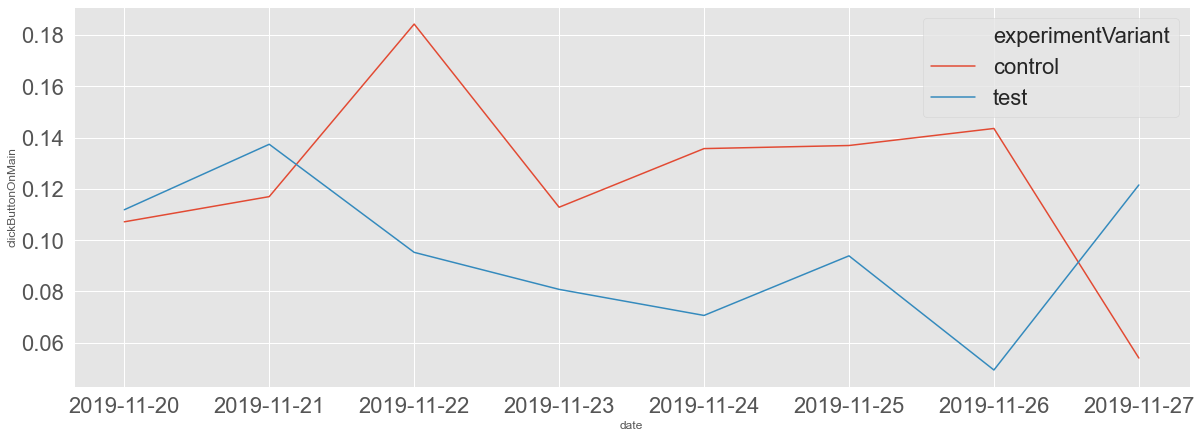

In [32]:
df_1 = df.groupby(['date','experimentVariant'], as_index = False)\
    .agg({'clickButtonOnMain':'mean', 'sessionDuration':'count'})
sns.lineplot(data=df_1, x="date", y="clickButtonOnMain" , hue="experimentVariant")

Имеются дни, когда конверт в клики был выше у тестовой группы. 

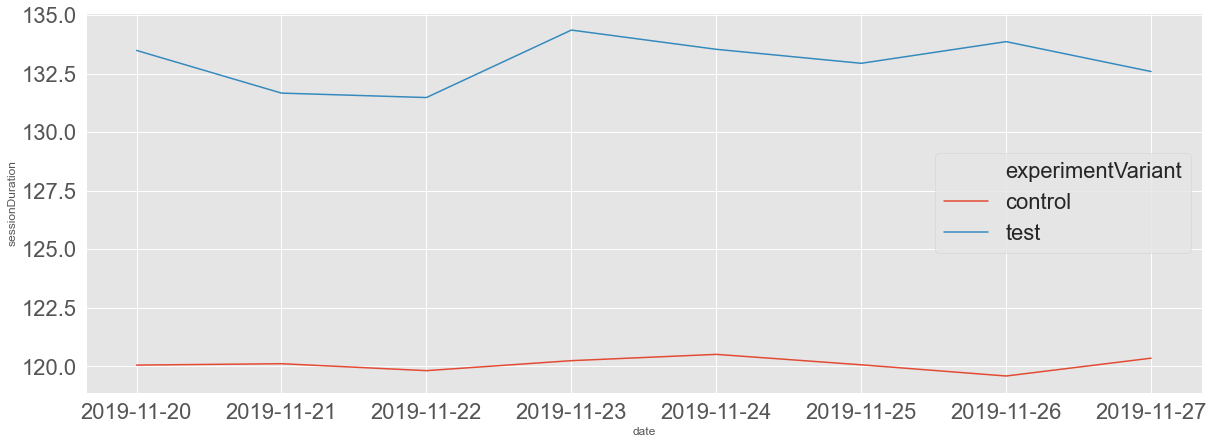

In [33]:
df_2 = df.groupby(['date','experimentVariant'], as_index = False)\
    .agg({'sessionDuration':'median' })
sns.lineplot(data=df_2, x="date", y='sessionDuration' , hue="experimentVariant")

В целом видим что среднее время сессии у тестовой группы за весь период  было выше

Посмотрим что там с sourceMedium. Рассмотрим тех, чья доля юзеров составляет более 2% юзеров

In [34]:
source = df.groupby(['sourceMedium','experimentVariant'], as_index = False)\
    .agg({'clickButtonOnMain':'mean', 'sessionDuration':'median', 'date':'count'})\
    .rename(columns = {'clickButtonOnMain':'conv_in_clik', 'date':'size_of_subsample','sessionDuration':'median_sessionDuration'})
source['share_of_users'] = source.apply(lambda x:x['size_of_subsample']/1458 if x['experimentVariant'] == "test"
                                                    else x['size_of_subsample']/1485, axis = 1 )*100
source.round(3).query('share_of_users>2')

,sourceMedium,experimentVariant,conv_in_clik,median_sessionDuration,size_of_subsample,share_of_users
0,(direct) / (none),control,0.120,119.913,209,14.074
1,(direct) / (none),test,0.102,132.216,205,14.060
3,bernum.com / referral,control,0.313,120.269,201,13.535
4,bernum.com / referral,test,0.153,133.647,131,8.985
19,google / cpc,control,0.048,120.042,147,9.899
20,google / cpc,test,0.066,132.888,152,10.425
21,google / organic,control,0.184,120.666,244,16.431
22,google / organic,test,0.184,132.601,256,17.558
32,maz.com / referral,control,0.065,119.716,612,41.212
33,maz.com / referral,test,0.034,133.695,647,44.376


Не у каждого канала привлечения уменьшился коверт в клики. При этом время сессии у всех выросло

Более 40% юзеров с maz.com / referral, при этом конверт в клики у них достаточно низкий. Отдельно посмотрим экстперемент без данного канала привлечения 

In [35]:
df.query('sourceMedium != "maz.com / referral"').groupby(['experimentVariant'], as_index = False)\
    .agg({'clickButtonOnMain':'mean', 'date':'count'})\
    .rename(columns = {'clickButtonOnMain':'conv_in_clik', 'date':'size_of_sample'})\
    .round(3)


,experimentVariant,conv_in_clik,size_of_sample
0,control,0.174,873
1,test,0.137,811


## Гипотезы

    1. Конверт в клики у тестовой группы ниже, чем у контрольной
    2. Среднее время сессии у тестовой группы выше, чем у контрольной
    
    Уровень значимости возьмем равным 95%

### Гипотеза #2

Посмотрим на распределение sessionDuration. Далее поймем, какой статистический метод будет лучше принять для проверки гипотезы. 

experimentVariant
control    AxesSubplot(0.125,0.125;0.775x0.755)
test       AxesSubplot(0.125,0.125;0.775x0.755)
Name: sessionDuration, dtype: object

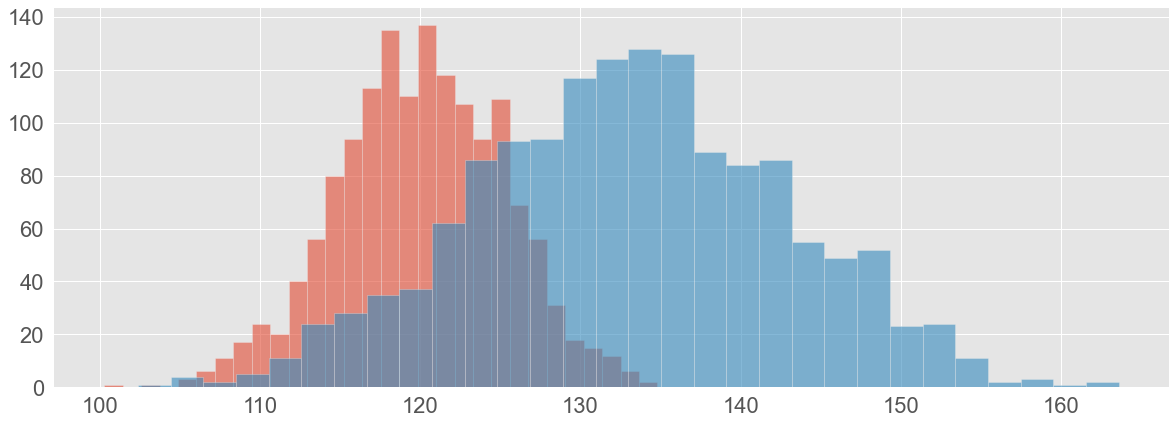

In [36]:
df.groupby('experimentVariant')['sessionDuration'].hist( bins =30, alpha =0.6)

control         AxesSubplot(0.1,0.15;0.363636x0.75)
test       AxesSubplot(0.536364,0.15;0.363636x0.75)
dtype: object

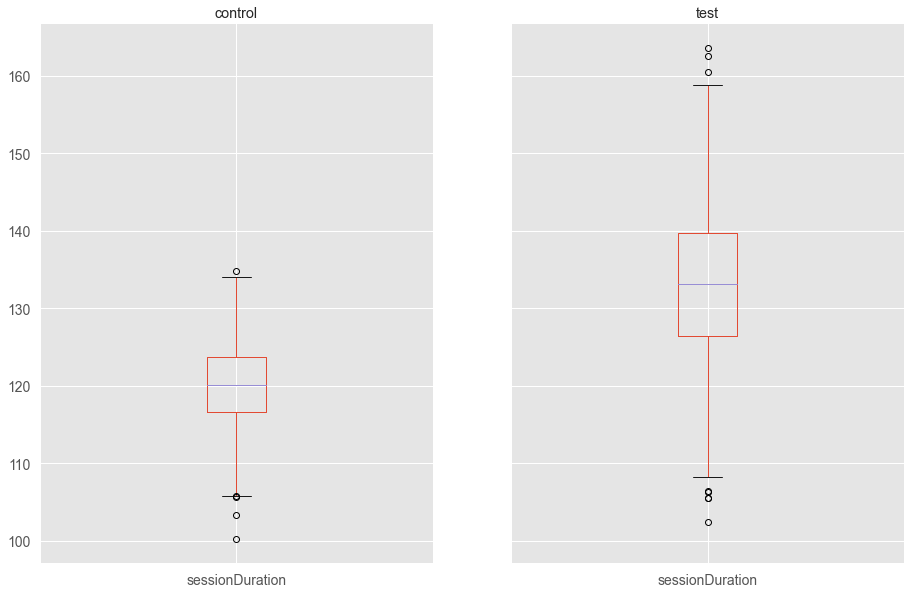

In [37]:
df[['sessionDuration','experimentVariant']].groupby(['experimentVariant',]).boxplot( fontsize=14, figsize=(15,10))

В целом распределение похоже на нормальное, сильных выбросов не наблюдаем.

Кажется, что у тестовой группы больший разброс, что было видно на подготовительном изучении
 

Проверим нормальность распределения выборки с помощью критерия Шапиро-Уилка.


In [38]:
x = df.query('experimentVariant == "control"').sessionDuration
y = df.query('experimentVariant == "test"').sessionDuration

In [39]:
res = stats.shapiro(x)
print('Критерий выборки Шапиро-Уилка control p-value: ', round(res[1],3))

res = stats.shapiro(y)
print('Критерий выборки Шапиро-Уилка test p-value: ', round(res[1],3))

Критерий выборки Шапиро-Уилка control p-value:  0.138
Критерий выборки Шапиро-Уилка test p-value:  0.431


p-value получилось достаточно большим, поэтому у нас нет оснований отвергнуть гипотезу о нормальном распределении.

#### Критерий Стьюдента

Данные условно нормальны. Проверим c помощью критерия Флигнера-Килина, равны ли дисперсии

In [40]:
res = stats.fligner(x, y)
print('p-value: ', res[1])

p-value:  2.8930452908569406e-82


Значение p-value низкое, поэтому гипотезу о равенстве дисперсий отвергаем. В двух выборках находятся разные наблюдаемые объекты, то есть выборки несвязные.

Проврим с помощью критерия Стьюдента равенство средних

In [41]:
res = stats.ttest_ind(x, y, equal_var=False)
print('p-value: ', res[1])

p-value:  8.574658e-318


p-value получилось очень маленьким, поэтому гипотезу о равенстве средних не принимаем.Т.е. тест статистически повлиял на среднее время, проведенное на сайте

#### Бутстрап

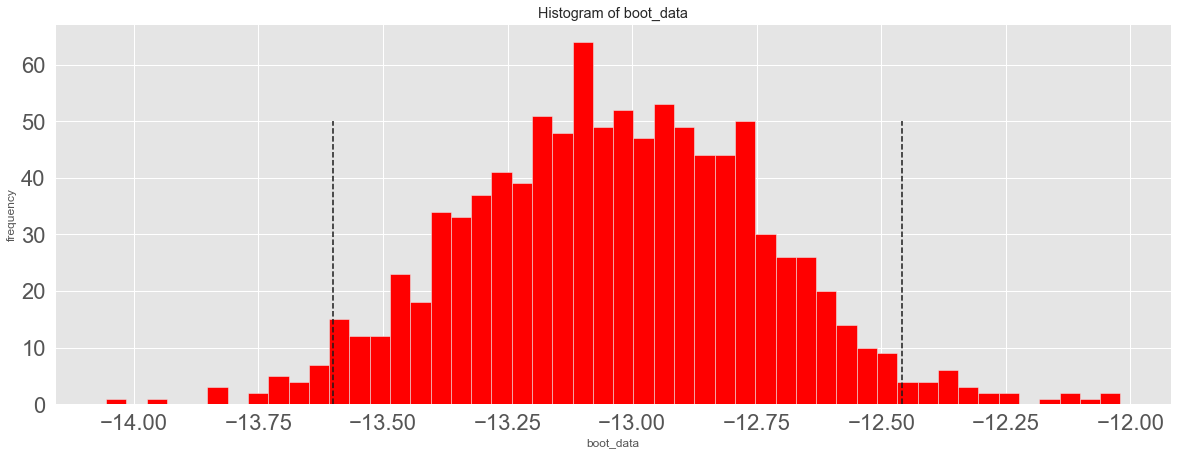

p-value:  0.0


In [42]:
# x - это df.query('experimentVariant == "control"').sessionDuration
# y - это df.query('experimentVariant == "test"').sessionDuration
res = get_bootstrap(x, y)
print('p-value: ', res["p_value"]) 


p-value получилось очень маленьким.


In [43]:
res["quants"] 

,0
0.025,-13.600618
0.975,-12.458181


ДИ не попадает в ноль => нулевую гипотезу не принимаем. Изменения статистически увеличили среднее время проведенное на сайте (разница средних контрольной и тестовой отрицптельное число)

#### Итог
Среднее время пребывания на сайте у тестовой группы статистически выше, чем у контрольной группы

### Гипотеза #1

Проверим гипотезу о том, что конверсия в клики у тестовой группы ниже чем у контрольной, с помощью одностороннего критерия Фишера

#### Точный критерий Фишера


In [44]:
data_1 = df.groupby(['experimentVariant'], as_index = False).agg({'clickButtonOnMain':'sum', 'sessionDuration':'count'})
data_2 = df.query(' sourceMedium != "maz.com / referral"').groupby(['experimentVariant'], as_index = False)\
            .agg({'clickButtonOnMain':'sum', 'sessionDuration':'count'})
data_1

,experimentVariant,clickButtonOnMain,sessionDuration
0,control,192,1485
1,test,133,1458


In [45]:
p = np.array([data_1.iloc[0][1], data_1.iloc[1][1]])
n = np.array([data_1.iloc[0][2], data_1.iloc[1][2]])
 
q = n - p

In [46]:
res = stats.fisher_exact([ p, q], alternative = 'less')
print('l p-value: ', round(res[1],6))
res = stats.fisher_exact([ p, q], alternative = 'greater')
print('g p-value: ', round(res[1],6))

l p-value:  0.999613
g p-value:  0.00059


Нулевая гипотеза о том, что у тестовой группы конверт в клики меньше чем у контрольной, принимается 

Нулевая гипотеза о том, что у тестовой группы конверт в клики больше чем у контрольной, не принимается 

Изменения статистически уменьшили конверт в клики.

In [47]:
# res = stats.fisher_exact([ p, q])
# # print('p-value: ', round(res[1],6))
# p-value получился достаточно маленькое, поэтому нулевая гипотеза о том что конверт в клики у контрольной группы выше равенстве
# долей не принимается. Тест статистически повлиял на конверт в клики.

Исключим source = maz.com / referra

In [48]:
p_1 = np.array([data_2.iloc[0][1], data_2.iloc[1][1]])
n_1 = np.array([data_2.iloc[0][2], data_2.iloc[1][2]])
q_1 = n_1 - p_1
res = stats.fisher_exact([ p, q], alternative = 'less')
print('l p-value: ', round(res[1],6))
res = stats.fisher_exact([ p_1, q_1], alternative = 'greater')
print('g p-value: ', round(res[1],6))

l p-value:  0.999613
g p-value:  0.020688


При   𝛼 = 0.05  изменения статистически уменьшили конверт в клики.

#### Итог
  Конверт в реги у тестовой группы уменьшился

## Итог

Целью эксперемента было зацепить пользователя и не дать ему уйти с сайта.

Проведя анализ эксперемента получили, что статистически уменьшилась коверсия в клики на главном экране. При этом увеличилось, среднее время проведенное на сайте.
В зависимости от того, какая метрика для бизнеса важнее, будет принято решение о том, принимать изменения или нет.